Connected to lcam (Python 3.11.10)

In [ ]:
import numpy as np

def gp_from_mck(M_delta: float, C: float, K: float, Ts: float, method: str = "tustin"):
    """
    将连续域二阶模型 Gp(s) = 1 / (M s^2 + C s + K) 离散化成 IIR: B(z^-1)/A(z^-1)
    参数:
      M_delta, C, K : 机械等效质量/阻尼/刚度
      Ts            : 采样周期 [s]
      method        : 'tustin' 或 'zoh_approx'
    返回:
      (b, a)  : 分子/分母（a[0]=1），对应 H(z) = (b0 + b1 z^-1 + ...)/(1 + a1 z^-1 + a2 z^-2)
    """
    # 连续域标准化为: G(s) = Kc / (s^2 + 2*zeta*wn*s + wn^2)
    wn = np.sqrt(K / M_delta)
    zeta = C / (2 * np.sqrt(M_delta * K))
    Kc = 1.0 / M_delta  # 使 G(s) = Kc / (s^2 + 2ζωn s + ωn^2)

    if method.lower() == "tustin":
        # 双线性变换 (Tustin): s ≈ (2/Ts) * (1 - z^-1) / (1 + z^-1)
        # 构造连续域分母与分子，再代换后收集 z^-1 次幂
        # 连续域: Num_c(s) = Kc, Den_c(s) = s^2 + 2ζωn s + ωn^2
        # 用符号推导较长，这里采用等效二阶极点映射 + DC 增益配准的简洁实现：
        r = np.exp(-zeta * wn * Ts)
        wd = wn * np.sqrt(max(1e-12, 1 - zeta**2))
        poles_d = np.array([r * np.exp(1j * wd * Ts), r * np.exp(-1j * wd * Ts)])  # 双共轭极点
        # 由极点得到分母 A(z)（a[0]=1 + a1 z^-1 + a2 z^-2）
        a = np.poly(poles_d).real
        a = a / a[0]

        # 给个二阶分子骨架并用 DC 增益配准 (|H(e^{j0})| = G(0))
        # 连续域 DC: G(0) = Kc / wn^2 = 1/K
        b = np.array([1.0, 0.0, 0.0], dtype=float)
        def H(b, a, w):
            z = np.exp(1j*w); num = b[0] + b[1]*z**(-1) + b[2]*z**(-2)
            den = 1 + a[1]*z**(-1) + a[2]*z**(-2)
            return num/den
        Gdc = 1.0 / K  # 连续域 DC 增益
        H0 = H(b, a, np.array([0.0]))[0]
        b = (Gdc / (H0 + 1e-16)) * b
        return b.real, a.real

    elif method.lower() == "zoh_approx":
        # 近似 ZOH：先把连续域极点离散 p_d = exp(p_c*Ts)，再 DC 配准
        p1 = -zeta * wn + 1j * wn * np.sqrt(max(0.0, 1 - zeta**2))
        p2 = np.conj(p1)
        poles_d = np.array([np.exp(p1 * Ts), np.exp(p2 * Ts)])
        a = np.poly(poles_d).real
        a = a / a[0]
        b = np.array([1.0, 0.0, 0.0], dtype=float)
        def H(b, a, w):
            z = np.exp(1j*w); num = b[0] + b[1]*z**(-1) + b[2]*z**(-2)
            den = 1 + a[1]*z**(-1) + a[2]*z**(-2)
            return num/den
        Gdc = 1.0 / K
        H0 = H(b, a, np.array([0.0]))[0]
        b = (Gdc / (H0 + 1e-16)) * b
        return b.real, a.real

    else:
        raise ValueError("method 仅支持 'tustin' 或 'zoh_approx'")


import numpy as np
import matplotlib.pyplot as plt

def db(x):  # 20*log10(|x|)
    return 20 * np.log10(np.maximum(1e-16, np.abs(x)))

def unwrap_phase_deg(x):
    return np.unwrap(np.angle(x)) * 180/np.pi

def freq_response_num_den(b: np.ndarray, a: np.ndarray, w: np.ndarray) -> np.ndarray:
    z = np.exp(1j*w)
    num = np.zeros_like(z, dtype=complex)
    den = np.ones_like(z, dtype=complex)
    for i, bi in enumerate(b):
        num += bi * z**(-i)
    for i in range(1, len(a)):
        den += a[i] * z**(-i)
    return num / den

def plot_frf_grid(w, curves, title_prefix="", legend_loc="best"):
    """
    curves: list of (label, complex FRF vector)
    w: rad/sample
    """
    fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
    for lab, H in curves:
        ax[0].plot(w, db(H), label=lab)
        ax[1].plot(w, unwrap_phase_deg(H), label=lab)
    ax[0].set_ylabel("Magnitude (dB)")
    ax[1].set_ylabel("Phase (deg)")
    ax[1].set_xlabel("Frequency (rad/sample)")
    ax[0].grid(True, which="both", ls=":")
    ax[1].grid(True, which="both", ls=":")
    ax[0].legend(loc=legend_loc)
    ax[0].set_title(f"{title_prefix} Magnitude")
    ax[1].set_title(f"{title_prefix} Phase")
    plt.tight_layout()


def generate_signal(N=2000, Ts=0.001, seed=42):
    # ---- 可调参数 ----
    # N  = 2000         # 序列长度
    # Ts = 0.001        # 采样周期[s]
    rng = np.random.default_rng(seed)
    t = np.arange(N) * Ts

    # ---- 构造参考 q_r：多正弦 + 低噪声 ----
    q_r = (
        0.02*np.sin(2*np.pi*1.2*t)
    + 0.01*np.sin(2*np.pi*3.5*t + 0.7)
    + 0.005*np.sin(2*np.pi*7.0*t + 1.1)
    + 0.0015*rng.standard_normal(N)
    )

    # ---- 构造扰动 d_hat：中频正弦 + 噪声，适度带宽 ----
    d_hat_raw = (
        0.25*np.sin(2*np.pi*5.0*t + 0.3)
    + 0.18*np.sin(2*np.pi*8.0*t + 1.4)
    + 0.05*rng.standard_normal(N)
    )

    # 用简单的“箱形平均”做个温和低通（FIR，绝对稳定）
    def moving_avg(x, L):
        if L <= 1:
            return x.copy()
        k = np.ones(L)/L
        y = np.convolve(x, k, mode="same")
        return y

    d_hat = moving_avg(d_hat_raw, L=9)

    # ---- 构造“控制输入” u：前馈(基于 q_r 的加速度近似) + 反馈(基于误差的温和校正) ----
    # 粗略“加速度”构造（有限差分+平滑），模拟前馈逆模型效果
    dq  = np.gradient(q_r, Ts)
    ddq = np.gradient(dq, Ts)
    ff  = moving_avg(0.8*ddq, L=7)   # 前馈分量（带低通）

    # 先临时定义一个“目标误差” e0：q_r 的轻微高频残差（模拟未完全被前馈补偿）
    e0 = moving_avg(q_r - moving_avg(q_r, L=51), L=9)

    # 反馈校正项：对 e0 进行弱比例+弱“微分”（差分）再低通
    de0 = np.gradient(e0, Ts)
    fb  = moving_avg(-0.6*e0 - 0.02*de0, L=11)

    # 合成控制输入
    u = ff + fb + 0.02*rng.standard_normal(N)

    # ---- 构造“误差” e：参考与输出的差；输出 q 由 (u + d_hat) 经简易低通得到
    # 用一个温和的二段低通逼近“被控对象”，避免不稳定
    q_lp1 = moving_avg(u + d_hat, L=13)
    q     = moving_avg(q_lp1, L=13)
    e     = q_r - q

    # 可选：简单幅值限幅，避免极值
    # for arr in (d_hat, q_r, e, u, q):
        # np.clip(arr, -1.0, 1.0, out=arr)

    # ---- 到这里你就得到了需要的四条序列 ----
    print("Generated sequences:")
    print("d_hat:", d_hat.shape, "q_r:", q_r.shape, "e:", e.shape, "u:", u.shape)
    # 如需保存
    # np.savez("synth_sequences.npz", Ts=Ts, t=t, d_hat=d_hat, q_r=q_r, e=e, u=u, q=q)
    # print("Saved to synth_sequences.npz")

    return d_hat, q_r, e, u


# 准备数据
N = 2000
Ts = 0.02  # 采样周期 [s]
d_hat_r, q_r, e, u = generate_signal(N=N, Ts=Ts, seed=42)

Generated sequences:
d_hat: (2000,) q_r: (2000,) e: (2000,) u: (2000,)


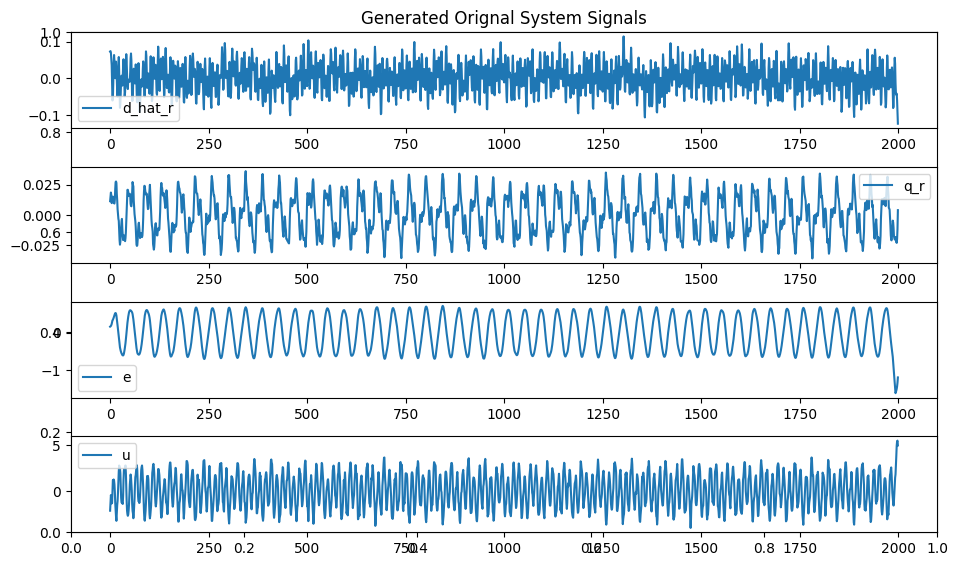

In [2]:
plt.figure(figsize=(10,6))
plt.title("Generated Orignal System Signals")
plt.subplot(4,1,1)
plt.plot(d_hat_r, label="d_hat_r")
plt.legend()
plt.subplot(4,1,2)
plt.plot(q_r, label="q_r")
plt.legend()
plt.subplot(4,1,3)
plt.plot(e, label="e")
plt.legend()
plt.subplot(4,1,4)
plt.plot(u, label="u")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Step 1: 识别 MΔ, C, K, fC, fS, v_s, dv, m_grid 辨识机电模型
from section2_model import Step1Identifier1D, finite_diff

q = q_r - e
# 计算速度和加速度
dq, ddq = finite_diff(q, 0.001)

# 构建位置网格
Ng = 9
qmin, qmax = np.percentile(q, [1, 99])  # 用覆盖区间去掉极端点
grid_centers = np.linspace(qmin, qmax, Ng)
grid_halfwidth = (qmax - qmin) / (Ng - 1)  # 标准选择


iden1 = Step1Identifier1D(
    grid_centers=grid_centers, grid_halfwidth=grid_halfwidth, n_grid=Ng,
    fric_v_s_bounds=(1e-4, 1.0), fric_dv_bounds=(1e-5, 1e-2),
    n_random=30, seed=0
).run(q, dq, ddq, u)


M_delta = iden1["M_delta"]; C = iden1["C"]; K = iden1["K"]
fC = iden1["fC"]; fS = iden1["fS"]
v_s = iden1["v_s"]; dv = iden1["dv_band"]
m_grid = iden1["m_grid"]
print(M_delta, C, K, fC, fS, v_s, dv)

-0.0002537008903227048 0.0012224561415057345 -2.6586848859104877 -0.07632465724959775 -0.6379008018439543 0.9972102147956321 0.009808545034374538


In [7]:
# Step 2: 计算扰动序列
from section2_model import reconstruct_disturbance_1d
d_hat = reconstruct_disturbance_1d(q, dq, ddq, iden1, grid_centers, grid_halfwidth)
print(d_hat)

[1.26356067 2.24701722 3.75275991 ... 2.87788834 2.30894745 0.88749927]


In [ ]:
# Step 3: 识别 2x2 闭环系统，得到 Geqr, Ged, GCqr, GCd
from closed_loop_id import CL2x2Identifier, recover_gfb_gff_from_2x2
from matplotlib import pyplot as plt
# === 你的数据 ===
# d_hat, q_r, e, u = ...  # N 点时域序列
# Ts = 0.001                # 采样周期 [s]（示例）
# === 用 Step1 的 MΔ,C,K 形成 Gp(z) ===
# M_delta, C, K = 2.0, 1.5, 50.0  # 示例，换成你的识别结果
b_p, a_p = gp_from_mck(float(M_delta), float(C), float(K), Ts, method="tustin")

# === 识别 2×2 ===
iden = CL2x2Identifier(nden=4, nb=4, n_random=100, seed=0).run(d_hat, q_r, e, u)

# === 频域反解 S, Gfb, Gff ===
w = np.linspace(0, np.pi, 1024)  # rad/sample
fr = recover_gfb_gff_from_2x2((iden["b_ed"], iden["a"]),
                              (iden["b_eqr"], iden["a"]),
                              (b_p, a_p),
                              w)
S, Gfb, Gff = fr["S"], fr["Gfb"], fr["Gff"]

# === 可选：也画 Gp 的频响，方便对比 ===
Gp = freq_response_num_den(b_p, a_p, w)

# === 画图 ===
plot_frf_grid(w, [("S", S), ("1-S", 1-S)], title_prefix="Sensitivity")
plot_frf_grid(w, [("Gfb", Gfb)], title_prefix="Feedback Gfb")
plot_frf_grid(w, [("Gff", Gff)], title_prefix="Feedforward Gff")
plot_frf_grid(w, [("Gp", Gp)], title_prefix="Plant Gp")
plt.show()

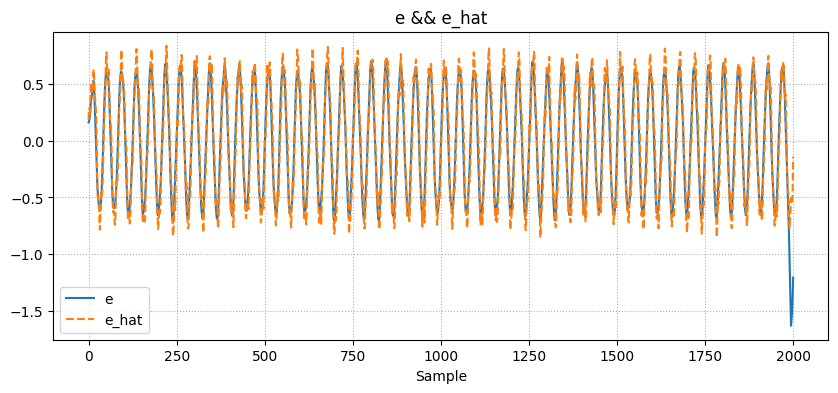

In [9]:
# 时域误差拟合结果
import numpy as np

def e_from_qr_batch(q_r: np.ndarray, b_eqr: np.ndarray, a: np.ndarray) -> np.ndarray:
    """
    用已辨识的 Geqr(z) 从 q_r 计算 e（批处理版）
    差分方程： y[k] = sum_{j=0..nb} b[j]*x[k-j] - sum_{i=1..na} a[i]*y[k-i]
    其中 a[0] = 1
    """
    x = np.asarray(q_r).reshape(-1)
    nb = len(b_eqr) - 1
    na = len(a) - 1
    y = np.zeros_like(x, dtype=float)

    for k in range(len(x)):
        # 前向卷积：分子
        acc = 0.0
        for j in range(nb + 1):
            if k - j >= 0:
                acc += b_eqr[j] * x[k - j]
        # 反馈：分母（注意符号为减号）
        for i in range(1, na + 1):
            if k - i >= 0:
                acc -= a[i] * y[k - i]
        y[k] = acc
    return y

class ErrorFromQrOnline:
    """
    在线（实时）计算 e(k) 的小器件：
      step(qr_k) -> 返回最新 e_k
    内部保存必要的 x/y 历史状态
    """
    def __init__(self, b_eqr: np.ndarray, a: np.ndarray):
        assert abs(a[0] - 1.0) < 1e-12, "a[0] 必须为 1"
        self.b = np.array(b_eqr, dtype=float)
        self.a = np.array(a, dtype=float)
        self.nb = len(self.b) - 1
        self.na = len(self.a) - 1
        self.xbuf = [0.0] * self.nb
        self.ybuf = [0.0] * self.na

    def step(self, qr_k: float) -> float:
        # y[k] = b0*x[k] + ... + b_nb*x[k-nb] - (a1*y[k-1] + ... + a_na*y[k-na])
        acc = self.b[0] * qr_k
        for j in range(1, self.nb + 1):
            acc += self.b[j] * (self.xbuf[j - 1] if j - 1 < len(self.xbuf) else 0.0)
        for i in range(1, self.na + 1):
            acc -= self.a[i] * (self.ybuf[i - 1] if i - 1 < len(self.ybuf) else 0.0)

        # 更新状态（最新样本放前面）
        if self.nb > 0:
            self.xbuf[1:] = self.xbuf[:-1]
            self.xbuf[0] = qr_k
        if self.na > 0:
            self.ybuf[1:] = self.ybuf[:-1]
            self.ybuf[0] = acc
        return acc

# 你从辨识里拿到的系数：
# iden = CL2x2Identifier(...).run(d_hat, q_r, e, u)
b_eqr = iden["b_eqr"]
a     = iden["a"]

# 批处理直接算整段 e_hat：
e_hat = e_from_qr_batch(q_r, b_eqr, a)

plt.figure(figsize=(10,4))
plt.plot(e, label="e")
plt.plot(e_hat, label="e_hat", linestyle="--")
plt.legend()
plt.title("e && e_hat")
plt.xlabel("Sample")
plt.grid(True, which="both", ls=":")
plt.show()

# 或者在线逐点：
# ef = ErrorFromQrOnline(b_eqr, a)
# e_hat_stream = [ef.step(x) for x in q_r]
# e_hat_stream = np.array(e_hat_stream)